In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
train=pd.read_csv("C:/Users/rwagh/Downloads/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv('C:/Users/rwagh/Downloads/house-prices-advanced-regression-techniques/test.csv')

In [3]:
print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)

Train Shape:  (1460, 81)
Test Shape:  (1459, 80)


train has 81 columns (79 features + id and target SalePrice) and 1460 entries
test has 80 columns (79 features + id) and 1459 entries

## CHECK FOR NULL VALUES

In [4]:
print(train.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


<AxesSubplot:>

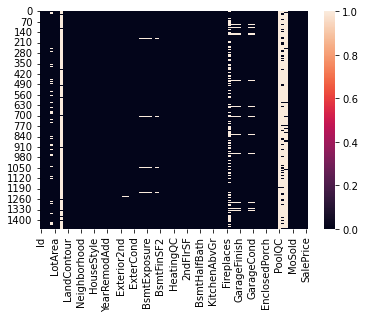

In [5]:
sns.heatmap(train.isnull())

In [6]:
print(test.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


<AxesSubplot:>

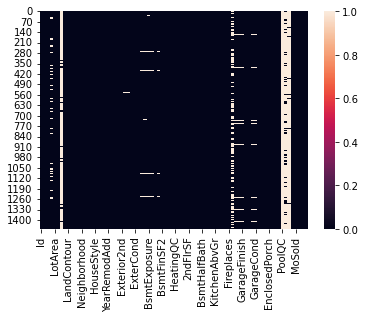

In [7]:
sns.heatmap(test.isnull())

Handling NULL data
We can see that ‘Alley’,’PoolQC’,’Fence’ and ‘MiscFeature’ columns have more than 70% of null values in both train and test data. So, we will drop these columns.
Also, we will drop ‘Id’ column. For non-categorical columns, we will handle null values by filling mean of the column.
For categorical columns, we will handle null values by filling mode of the column.

FOR TRAIN DATA

In [8]:
cat_col_train = ['FireplaceQu','GarageType','GarageFinish','MasVnrType','BsmtQual',
           'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
          'GarageQual','GarageCond']

ncat_col_train = ['LotFrontage','GarageYrBlt','MasVnrArea']

In [9]:
for i in cat_col_train:
    train[i] = train[i].fillna(train[i].mode()[0])
    
for j in ncat_col_train:
    train[j] = train[j].fillna(train[j].mean())

FOR TEST DATA

In [10]:
cat_col_test = ['FireplaceQu','GarageType','GarageFinish','MasVnrType','BsmtQual',
           'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
          'GarageQual','GarageCond','MSZoning','Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional','SaleType']

ncat_col_test = ['LotFrontage','GarageYrBlt','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath',
                'BsmtHalfBath','GarageCars','GarageArea']

In [11]:
for i in cat_col_test:
    test[i] = test[i].fillna(test[i].mode()[0])
    
for j in ncat_col_test:
    test[j] = test[j].fillna(test[j].mean())

Drop Columns

In [12]:
to_drop = ['Id','Alley','PoolQC','Fence','MiscFeature']

for k in to_drop:
    train.drop([k], axis = 1, inplace = True)
    test.drop([k], axis = 1, inplace = True)

<AxesSubplot:>

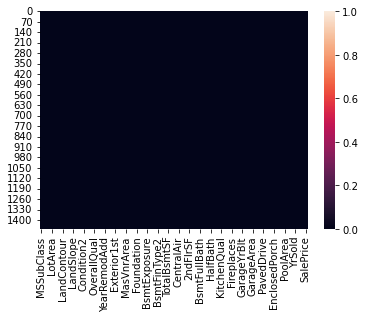

In [13]:
sns.heatmap(train.isnull())

<AxesSubplot:>

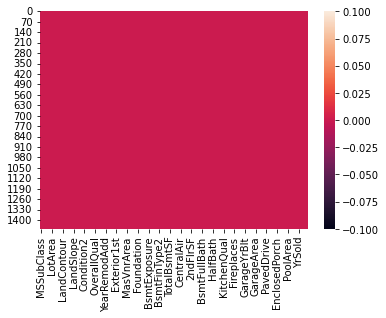

In [14]:
sns.heatmap(test.isnull())

In [15]:
print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)

Train Shape:  (1460, 76)
Test Shape:  (1459, 75)


It is observed that for some columns in train data few categories are not present but available in test data. So, we will concat test data to train data, then perform one hot encoding on all categorical columns.

In [16]:
final_df = pd.concat([train,test], axis = 0)
final_df.shape

(2919, 76)

In [17]:
all_cat_col = ['MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
              'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl',
              'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual',
              'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir',
              'Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual',
              'GarageCond','PavedDrive','SaleType','SaleCondition']

In [18]:
def cat_onehot_encoding(multicol):
    df_final = final_df
    i = 0
    for fields in multicol:
        print(fields)
        df1 = pd.get_dummies(final_df[fields],drop_first = True)
        
        final_df.drop([fields], axis = 1, inplace = True)
        if i==0:
            df_final = df1.copy()
        else:
            df_final = pd.concat([df_final,df1], axis=1)
        i = i+1
    
    df_final = pd.concat([final_df,df_final], axis = 1)
    
    return df_final

In [19]:
final_df = cat_onehot_encoding(all_cat_col)

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
SaleType
SaleCondition


In [20]:
final_df.shape

(2919, 237)

In [21]:
final_df = final_df.loc[:,~final_df.columns.duplicated()]
final_df.shape

(2919, 177)

In [22]:
final_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,0,1,0,0,0,1,0
